# Topk sampling Technique

<div class="alert alert-block alert-info">
<b>Wht we need this sampling techniques </b> 
 
We have trainined the  LLM model with the dataset. Below is what we performed.
1. We calculated the Loss
2. Started minimizing the Loss using backprogration
3. Updated the Weights of the model (defined in transformer Block , which was ~164M parameters)

After all this , we started using Model to perform some prediction of next input sequence.

Check the output below

![image.png](attachment:a6517a5c-25b7-4569-9a11-c3b20e6a56ff.png)

From the output of the LLM model , we see that the text that is generated is not what we really want. It actually doesnot make sense . 

So inorder to make the Model predict text/input sequence that are more contexually correct , we need some stratergy to control this random.

Meaning some way to make this predictions more meaningfull.

We saw one of the technique called "Temperature Sampling" .

In this technique we changed the probability distribution by adding a value that is greater then zero to Logits , then use the multinomial to sample the next predicted token from probability distribution


</div>

<div class="alert alert-block alert-info">
<b> 2 Techniques to control the randomness of predictions </b> 
 
The 2 techniques use of improve the predictions are below

1. Temperature Scaling
2. Top K-sampling   --> This Notebook we cover

We will be covering Temperature Scaling in this notebook

</div>

<div class="alert alert-block alert-info">
<b> Temperature Scaling in Brief </b> 
 
We saw one of the technique called "Temperature Sampling" .

In this  add a value that is greater then zero to Logits , then use the multinomial to sample the next predicted token from probability distribution

Below is the workflow of how it is done

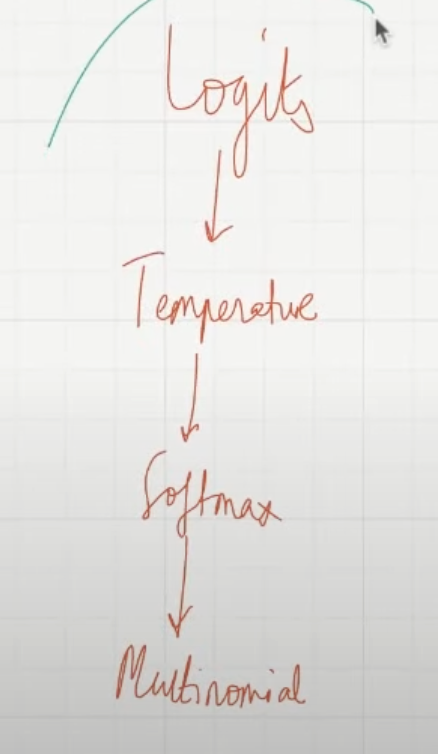

</div>

<div class="alert alert-block alert-info">
<b> Problem with the Temperature Scaling alone </b> 


In the previous section, we implemented a probabilistic sampling approach coupled with
temperature scaling to increase the diversity of the outputs. 

We saw that higher
temperature values result in more uniformly distributed next-token probabilities, which
result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting
the most probable token. 

This method allows for exploring less likely but potentially more
interesting and creative paths in the generation process. 

<font color="red"> However, One downside of this <font>
approach is that it sometimes leads to grammatically incorrect or completely nonsensical
outputs such as "every effort moves you pizza".

</div>

<div class="alert alert-block alert-info">
<b> TopK sampling Technique </b> 

In this section, we introduce another concept called top-k sampling, which, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.
    


TopK sampling technique is to restrict the sampled tokens to the TopK most likely tokens and exclude all the others token.
E.g , if we specify the TopK=3 , then follow things happen.

1. We generate the logits tensors for given inpit sequence.
2. We then sample the logits to TopK samples that has highest values.
3. In logits matric , replace all the other token with -inf , expect the one sampled as pr TopK
4. Then we divide the logits tensor with just TopK samples , with temperature value (if specified) . This is combinatiion of TopK + Temperature
5. We then apply the softmax to this logits , to convert this to the probability matrix
6. Then last we apply torch.multinomial to get next predictd token sampled from probability distrubtion

Above the Steps , we carry out

</div>

<div class="alert alert-block alert-info">
<b> TopK sampling Technique : What Happens </b> 

<p>

Everything mentioned above is shown below in pictures

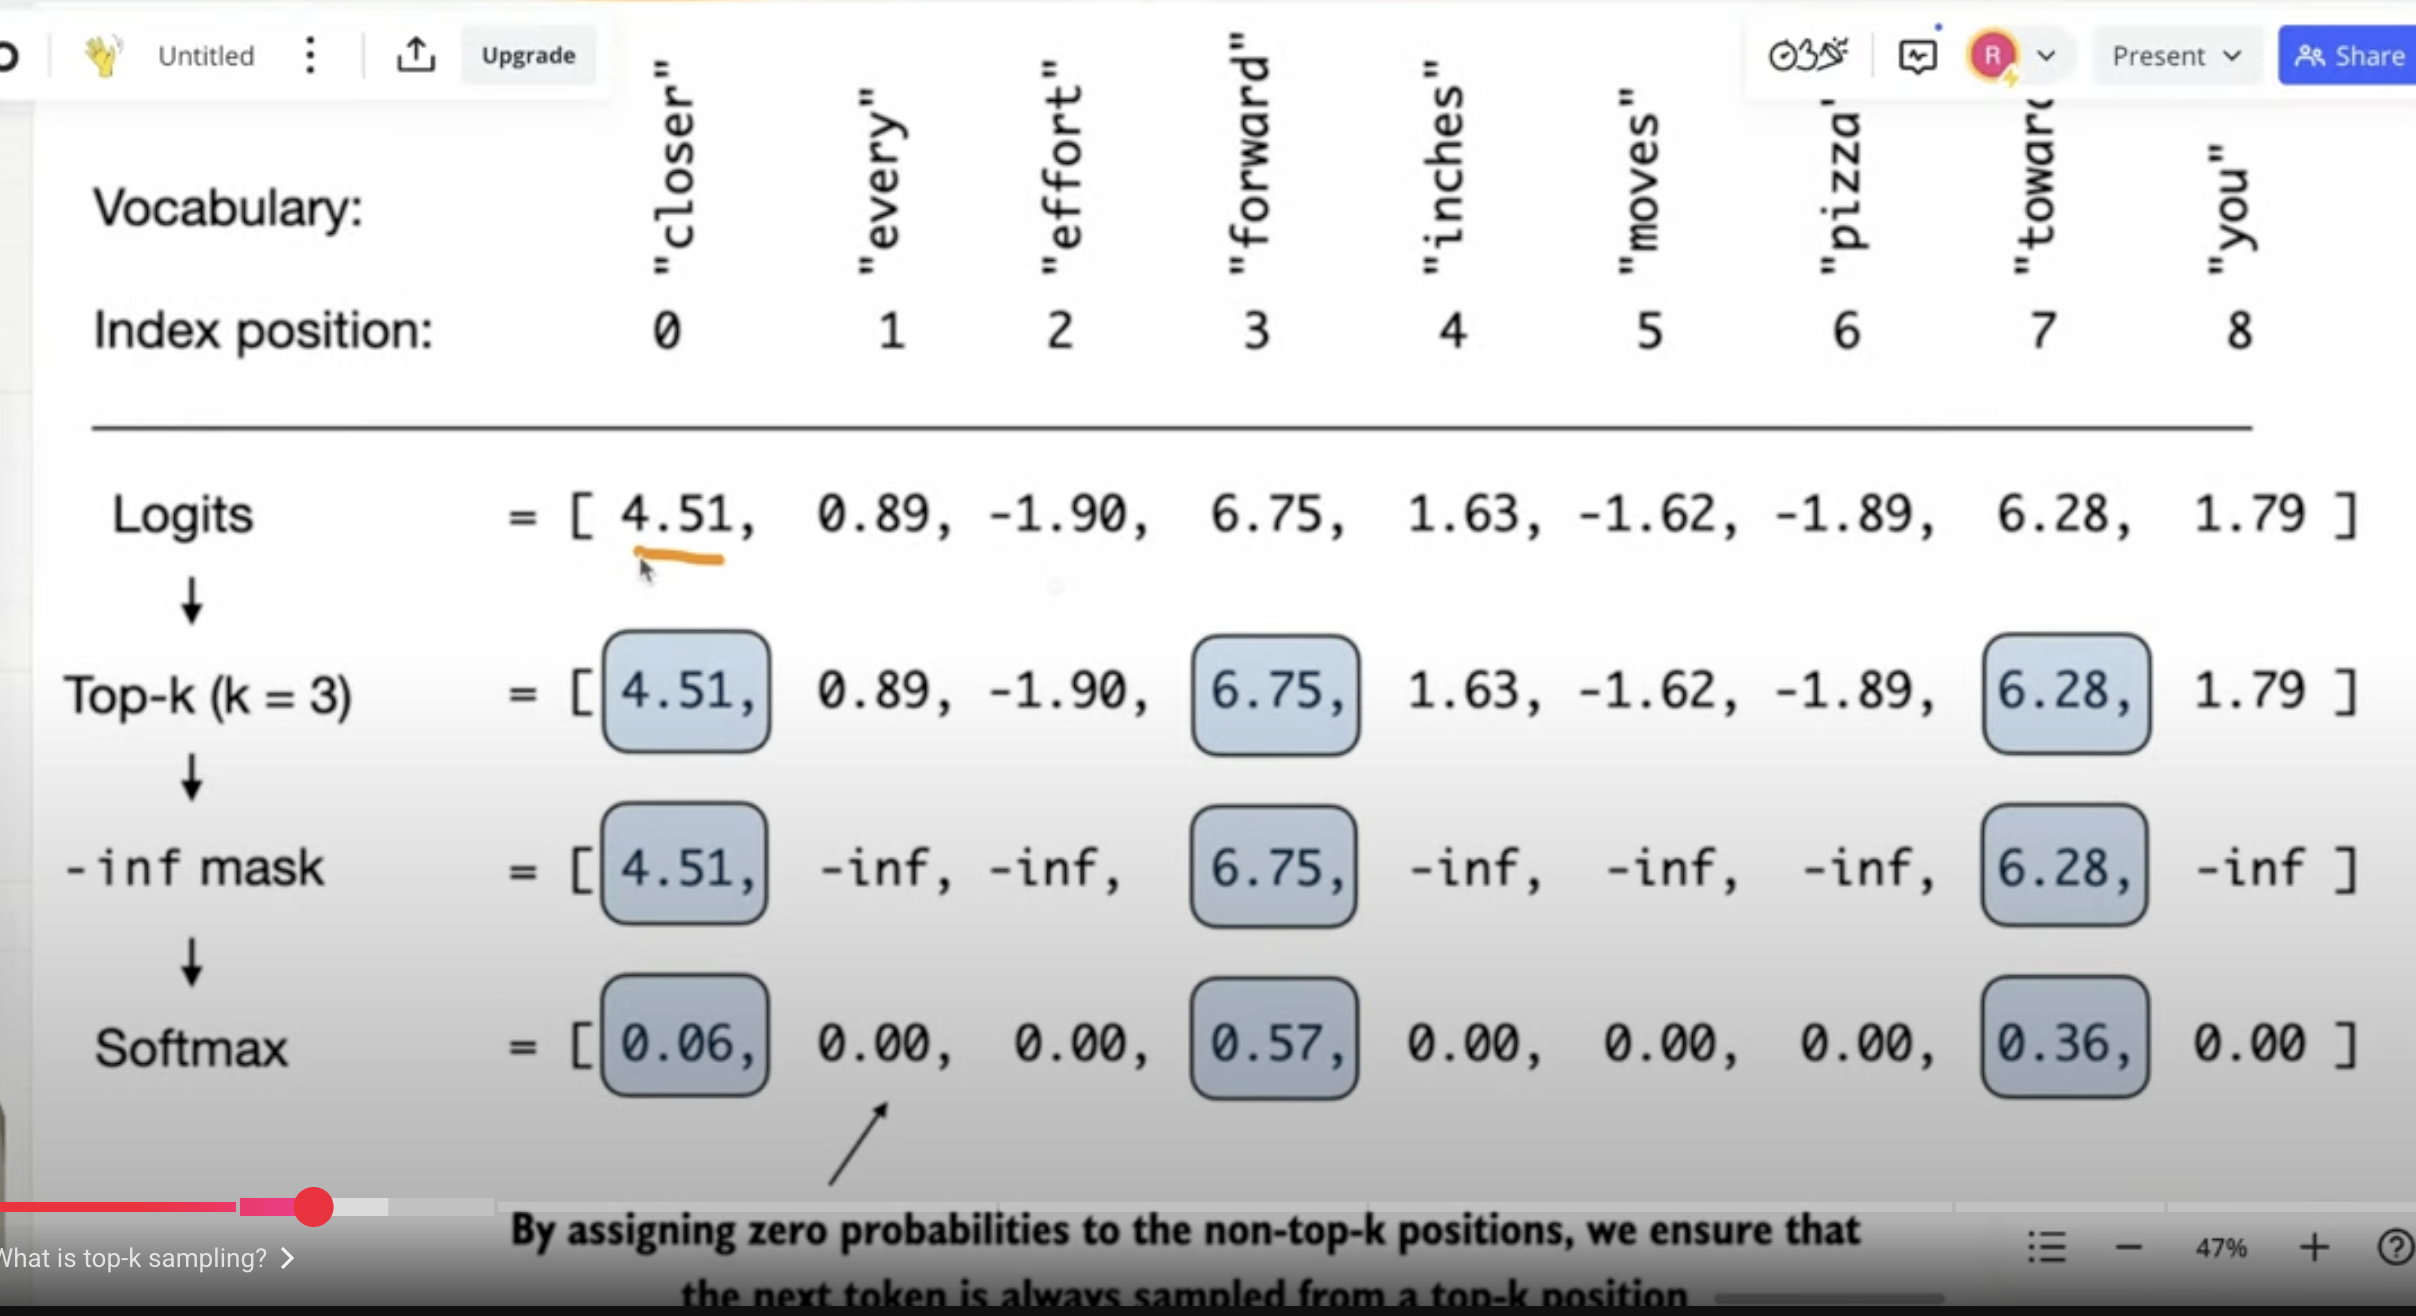
</p>

</div>

<div class="alert alert-block alert-info">
<b> TopK sampling Technique : WorkFlow to follow </b> 
<p>

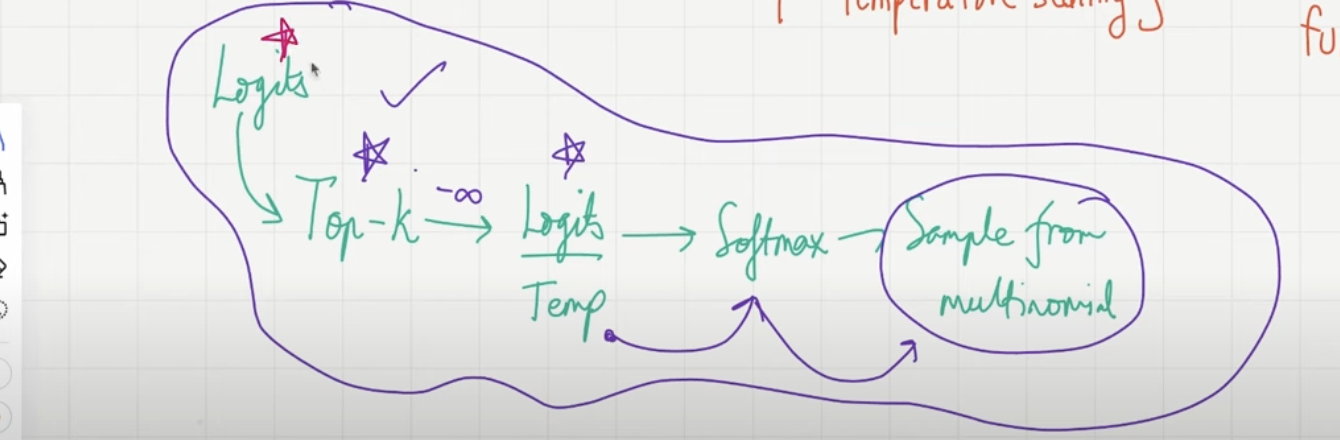

</p>
</div>

# Lets check a example of TopK sampling technique

In [4]:
import torch
import torch.nn as nn

# Lets define a samll vocab of size=9
# Inverse the vocab as well
vocab={
  "closer" :0,
  "every":  1,
  "efforts":2,
  "forward":3,
  "inches" :4,
  "moves"  :5,
  "pizza"  :6,
  "toward" :7,
  "you"    :8,
}

inverse_vocab = {v : k for k , v in vocab.items()}
print(inverse_vocab)


# The # of columns in logits matrix is equal to our vocab_size =9
# In the model we have a vocal_size=50257 

next_token_logits = torch.tensor (
    [4.51 , 0.89 , -1.90 , 6.75 , 1.63 , -1.62 , -1.89, 6.28 , 1.79 ]
)

{0: 'closer', 1: 'every', 2: 'efforts', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [6]:
topk=3  # We define the TopK sampling value
top_logits , topK_pos = torch.topk(next_token_logits ,topk)

print("Top sampled Logits: ",top_logits)
print("Top sampled Logits indexs: ",topK_pos)

Top sampled Logits:  tensor([6.7500, 6.2800, 4.5100])
Top sampled Logits indexs:  tensor([3, 7, 0])


<div class="alert alert-block alert-success">

Subsequently, we apply PyTorch's where function to set the logit values of tokens that are
below the lowest logit value within our top-3 selection to negative infinity (-inf).
    
</div>

In [8]:
print(top_logits[-1])

tensor(4.5100)


In [9]:
#filter and get the index for the provided condtion
torch.where(next_token_logits < top_logits[-1]) 

(tensor([1, 2, 4, 5, 6, 8]),)

In [14]:
# Wehere clause reaqd as below
# Filter condition :- get index of all values that is less tensor(4.5100)
# then Apply the -inf , on all those indexes in input tensor
# Return a new tensore with this changes

new_logits = torch.where( next_token_logits < top_logits[-1], 
                          torch.tensor(float("-inf")), 
                          next_token_logits)

In [15]:
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


<div class="alert alert-block alert-success">

Lastly, let's apply the softmax function to turn these into next-token probabilities:

You can now see, we are only left with TopK sampled and rest masked to converted to zero , after softmax.

This is the set the next predicted toekn will be sampled after we apply multinomial
</div>

In [16]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


# Combine the Temperature and TopK Sampling

<div class="alert alert-block alert-success">

We can now apply the temperature scaling and multinomial function for probabilistic
sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by
modifying the text generation function.

</div>

<div class="alert alert-block alert-success">

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and
add these concepts to modify the generate_simple function we used to generate text via
the LLM earlier, creating a new generate function:

</div>

# The next Notebook after this has all the code from scratch until this point.

## PTO to next notebook